## Environment

In [1]:
#Using latest version of LangChain
import langchain
langchain.__version__

'0.3.17'

### Install Packages

In [2]:
# !pip install langchain_community tiktoken langchain-groq langchainhub chromadb langchain
# !pip install --quiet --upgrade langchain-text-splitters langchain-community langgraph

In [3]:
#pip install langchain langchain_community requests


In [4]:
from langchain_community.tools.edenai import EdenAiTextToSpeechTool


In [5]:
eden_tts_tool = EdenAiTextToSpeechTool(
    providers=["google"],  # Choose "google", "microsoft", or "amazon"
    language="en",
    voice="FEMALE",
)


In [6]:
def eden_tts_node(state):
    generated_text = generated_text = state.get("generation","No text found")
    audio_output = eden_tts_tool.run(generated_text)
    return {"generation": audio_output}


In [7]:
from langgraph.graph import END, StateGraph, START

### API Keys

In [8]:
import os, json, re, getpass
from dotenv import load_dotenv

load_dotenv(".env", override=True)

True

In [9]:
def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

In [10]:
#Check for Groq API Key
_set_env("GROQ_API_KEY")

In [11]:
#Check for Tavily API Key
_set_env("TAVILY_API_KEY")

### Libraries

In [12]:
from langchain_groq import ChatGroq
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_chroma import Chroma

from typing import Literal
from langchain_core.prompts import ChatPromptTemplate
from langchain_community.document_loaders import WebBaseLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from pydantic import BaseModel, Field

from pprint import pprint

USER_AGENT environment variable not set, consider setting it to identify your requests.


## Selecting Components

### Chat Model

In [13]:
llm = ChatGroq(model="llama3-8b-8192") #llama3-8b-8192, llama-3.1-8b-instant, llama3-groq-8b-8192-tool-use-preview, llama3-groq-70b-8192-tool-use-preview 

### Embedding Model

In [14]:
embed_model = HuggingFaceEmbeddings(model_name="sentence-transformers/all-mpnet-base-v2")

e:\JIO QTR 3\LLM\myenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Vector Store

In [15]:
# vector_store = Chroma(embedding_function=embed_model)

## Retriever

First, we index 3 pages.

In [16]:
urls = [
    "https://www.jioinstitute.edu.in/academics/artificial-intelligence-data-science",
    "https://www.jioinstitute.edu.in/academics/study-abroad",
    "https://www.jioinstitute.edu.in/experiential-learning"
]

In [17]:
docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

In [18]:
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=100, chunk_overlap=50
)
doc_splits = text_splitter.split_documents(docs_list)

In [19]:
# Add to vectorDB
vectorstore = Chroma.from_documents(
    documents=doc_splits,
    collection_name="rag-chroma",
    embedding=embed_model,
)

In [20]:
retriever = vectorstore.as_retriever()

## Define Test Questions

In [21]:
#STEP 0 (optional): ADD - Test question for new tool

In [22]:
question_search = "Which players in IPL 2025 are expected to draw significant bids"

In [23]:
question_doc = "What are the highlights of the PGP in Data Science and AI course at Jio Institute"

## LLMs

### Router

In [24]:
from typing import Literal
from langchain_core.prompts import ChatPromptTemplate
from pydantic import BaseModel, Field

In [25]:
# Data model
##STEP 1: ADD - New tool to Literal
class RouteQuery(BaseModel):
    """Route a user query to the most relevant datasource."""

    datasource: Literal["vectorstore", "web_search"] = Field(
        ...,
        description="Given a user question choose to route it to web search or a vectorstore.",
    )

In [26]:
# LLM with function call
structured_llm_router = llm.with_structured_output(RouteQuery)

In [27]:
##STEP 2: MODIFY PROMPT to route to your new tool accordingly
# Prompt
system = """You are an expert at routing a user question to a vectorstore or web search.
The vectorstore contains documents related to agents, prompt engineering, and adversarial attacks.
Use the vectorstore for questions on these topics. Otherwise, use web-search."""
route_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "{question}"),
    ]
)

In [28]:
question_router = route_prompt | structured_llm_router
print(
    question_router.invoke(
        {"question": question_search}
    )
)
print(question_router.invoke({"question": question_doc}))

datasource='web_search'
datasource='vectorstore'


### Retrieval Grader

In [29]:
# Data model
class GradeDocuments(BaseModel):
    """Binary score for relevance check on retrieved documents."""

    binary_score: str = Field(
        description="Documents are relevant to the question, 'yes' or 'no'"
    )

In [30]:
# LLM with function call
structured_llm_grader = llm.with_structured_output(GradeDocuments)

In [31]:
# Prompt
system = """You are a grader assessing relevance of a retrieved document to a user question. \n 
    If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n
    It does not need to be a stringent test. The goal is to filter out erroneous retrievals. \n
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."""
grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Retrieved document: \n\n {document} \n\n User question: {question}"),
    ]
)

In [32]:
retrieval_grader = grade_prompt | structured_llm_grader
docs = retriever.invoke(question_doc)
doc_txt = docs[1].page_content
print(retrieval_grader.invoke({"question": question_doc, "document": doc_txt}))

binary_score='yes'


In [33]:
docs

[Document(id='cb68cc89-f349-4552-875c-07536801fb8b', metadata={'description': "Explore Jio Institute's artificial intelligence course offerings. Dive into the world of AI and data science with our cutting-edge programmes. Apply now!", 'language': 'en', 'source': 'https://www.jioinstitute.edu.in/academics/artificial-intelligence-data-science', 'title': 'PGP in Artificial Intelligence & Data Science - Jio Institute'}, page_content='Jio Institute has formulated a seamless digital admissions process to apply to its academic programmes. We invite applications from meritorious students from accross the globe. Eligibility for PGP in Artificial Intelligence & Data Science :A four-year undergraduate degree or its equivalent, in the field of Engineering/Science/ Mathematics and Statistics with minimum 50 per cent or equivalent CGPA. A postgraduate degree (if the undergraduate degree is of three years) in the field of'),
 Document(id='64a38ccc-8ed8-4d5b-aad5-bd170e306b65', metadata={'description'

### Generate

In [34]:
from langchain import hub
from langchain_core.output_parsers import StrOutputParser

In [35]:
# Prompt
prompt = hub.pull("rlm/rag-prompt")

In [36]:
prompt

ChatPromptTemplate(input_variables=['context', 'question'], input_types={}, partial_variables={}, metadata={'lc_hub_owner': 'rlm', 'lc_hub_repo': 'rag-prompt', 'lc_hub_commit_hash': '50442af133e61576e74536c6556cefe1fac147cad032f4377b60c436e6cdcb6e'}, messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['context', 'question'], input_types={}, partial_variables={}, template="You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.\nQuestion: {question} \nContext: {context} \nAnswer:"), additional_kwargs={})])

In [37]:
# Post-processing
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

In [38]:
# Chain
rag_chain = prompt | llm | StrOutputParser()

In [39]:
# Run
generation = rag_chain.invoke({"context": docs, "question": question_doc})
print(generation)

The PGP in Data Science and AI course at Jio Institute has a comprehensive and rigorous curriculum that covers foundation and advanced courses to train future-ready full-stack data scientists and AI architects. The program's highlights include training in AI and data science, with a focus on inter-disciplinary skills and hands-on learning through live projects.


### Hallucination Grader

In [40]:
# Data model
class GradeHallucinations(BaseModel):
    """Binary score for hallucination present in generation answer."""

    binary_score: str = Field(
        description="Answer is grounded in the facts, 'yes' or 'no'"
    )

In [41]:
# LLM with function call
structured_llm_grader = llm.with_structured_output(GradeHallucinations)

In [42]:
# Prompt
system = """You are a grader assessing whether an LLM generation is grounded in / supported by a set of retrieved facts. \n 
     Give a binary score 'yes' or 'no'. 'Yes' means that the answer is grounded in / supported by the set of facts."""
hallucination_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Set of facts: \n\n {documents} \n\n LLM generation: {generation}"),
    ]
)

In [43]:
hallucination_grader = hallucination_prompt | structured_llm_grader
hallucination_grader.invoke({"documents": docs, "generation": generation})

GradeHallucinations(binary_score='yes')

In [44]:
docs

[Document(id='cb68cc89-f349-4552-875c-07536801fb8b', metadata={'description': "Explore Jio Institute's artificial intelligence course offerings. Dive into the world of AI and data science with our cutting-edge programmes. Apply now!", 'language': 'en', 'source': 'https://www.jioinstitute.edu.in/academics/artificial-intelligence-data-science', 'title': 'PGP in Artificial Intelligence & Data Science - Jio Institute'}, page_content='Jio Institute has formulated a seamless digital admissions process to apply to its academic programmes. We invite applications from meritorious students from accross the globe. Eligibility for PGP in Artificial Intelligence & Data Science :A four-year undergraduate degree or its equivalent, in the field of Engineering/Science/ Mathematics and Statistics with minimum 50 per cent or equivalent CGPA. A postgraduate degree (if the undergraduate degree is of three years) in the field of'),
 Document(id='64a38ccc-8ed8-4d5b-aad5-bd170e306b65', metadata={'description'

In [45]:
generation

"The PGP in Data Science and AI course at Jio Institute has a comprehensive and rigorous curriculum that covers foundation and advanced courses to train future-ready full-stack data scientists and AI architects. The program's highlights include training in AI and data science, with a focus on inter-disciplinary skills and hands-on learning through live projects."

### Answer Grader

In [46]:
# Data model
class GradeAnswer(BaseModel):
    """Binary score to assess answer addresses question."""

    binary_score: str = Field(
        description="Answer addresses the question, 'yes' or 'no'"
    )

In [47]:
# LLM with function call
structured_llm_grader = llm.with_structured_output(GradeAnswer)

In [48]:
# Prompt
system = """You are a grader assessing whether an answer addresses / resolves a question \n 
     Give a binary score 'yes' or 'no'. Yes' means that the answer resolves the question."""
answer_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "User question: \n\n {question} \n\n LLM generation: {generation}"),
    ]
)

In [49]:
answer_grader = answer_prompt | structured_llm_grader
answer_grader.invoke({"question": question_doc, "generation": generation})

GradeAnswer(binary_score='yes')

In [50]:
print(question_doc, "\n\n", generation)

What are the highlights of the PGP in Data Science and AI course at Jio Institute 

 The PGP in Data Science and AI course at Jio Institute has a comprehensive and rigorous curriculum that covers foundation and advanced courses to train future-ready full-stack data scientists and AI architects. The program's highlights include training in AI and data science, with a focus on inter-disciplinary skills and hands-on learning through live projects.


### Question Re-writer

In [51]:
# Prompt
system = """You are a question re-writer that converts an input question to a better version that is optimized \n 
     for vectorstore retrieval. Look at the input and try to reason about the underlying semantic intent / meaning. \n 
     Only return the rewritten question and nothing else."""
re_write_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        (
            "human",
            "Here is the initial question: \n\n {question} \n Formulate an improved question.",
        ),
    ]
)

In [52]:
question_doc

'What are the highlights of the PGP in Data Science and AI course at Jio Institute'

In [53]:
question_rewriter = re_write_prompt | llm | StrOutputParser()
question_rewriter.invoke({"question": question_doc})

'What are the key takeaways and curriculum strengths of the Postgraduate Programme in Data Science and AI offered by Jio Institute?'

## Tools

### Search Tool

In [54]:
from langchain_community.tools.tavily_search import TavilySearchResults

web_search_tool = TavilySearchResults(k=3)

In [55]:
##STEP 3: ADD a new tool here

## Construct the Graph 

Capture the flow in as a graph.

### Define Graph State

We will define a graph.

A `state` object that it passes around to each node.

Our state will have 3 attributes - `question`, `generation` and `documents`.

Each node in our graph will update to it.

In [56]:
from typing import List

from typing_extensions import TypedDict


class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        documents: list of documents
    """

    question: str
    generation: str
    documents: List[str]

### Define Graph Flow 

We can lay out an agentic RAG graph like this:

* The state has a set of attributes
* Each node will update the state
* Conditional edges decide which node to visit next

#### Nodes

In [57]:
from langchain.schema import Document

In [58]:
def retrieve(state):
    """
    Retrieve documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("---RETRIEVE---")
    question = state["question"]

    # Retrieval
    documents = retriever.invoke(question)
    return {"documents": documents, "question": question}

In [59]:
def generate(state):
    """
    Generate answer

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    print("---GENERATE---")
    question = state["question"]
    documents = state["documents"]

    # RAG generation
    generation = rag_chain.invoke({"context": documents, "question": question})
    return {"documents": documents, "question": question, "generation": generation}

In [60]:
def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with only filtered relevant documents
    """

    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    question = state["question"]
    documents = state["documents"]

    # Score each doc
    filtered_docs = []
    for d in documents:
        score = retrieval_grader.invoke(
            {"question": question, "document": d.page_content}
        )
        grade = score.binary_score
        if grade == "yes":
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(d)
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            continue
    return {"documents": filtered_docs, "question": question}

In [61]:
question_rewriter

ChatPromptTemplate(input_variables=['question'], input_types={}, partial_variables={}, messages=[SystemMessagePromptTemplate(prompt=PromptTemplate(input_variables=[], input_types={}, partial_variables={}, template='You are a question re-writer that converts an input question to a better version that is optimized \n \n     for vectorstore retrieval. Look at the input and try to reason about the underlying semantic intent / meaning. \n \n     Only return the rewritten question and nothing else.'), additional_kwargs={}), HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['question'], input_types={}, partial_variables={}, template='Here is the initial question: \n\n {question} \n Formulate an improved question.'), additional_kwargs={})])
| ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x000002685B65CA10>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x000002685B4FBDD0>, model_name='llama3-8b-8192', model_kwargs={}, groq_ap

In [62]:
def transform_query(state):
    """
    Transform the query to produce a better question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates question key with a re-phrased question
    """

    print("---TRANSFORM QUERY---")
    question = state["question"]
    documents = state["documents"]

    # Re-write question
    better_question = question_rewriter.invoke({"question": question})
    return {"documents": documents, "question": better_question}

In [63]:
def web_search(state):
    """
    Web search based on the re-phrased question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with appended web results
    """

    print("---WEB SEARCH---")
    question = state["question"]

    # Web search
    docs = web_search_tool.invoke({"query": question})
    web_results = "\n".join([d["content"] for d in docs])
    web_results = Document(page_content=web_results)

    #Condition for Adaptive RAG, that has a flow of web search without a retrieval step first
    if "documents" in state.keys():
        documents = state["documents"]
        documents.append(web_results)
        return {"documents": documents, "question": question}
    
    else:
        return {"documents": web_results, "question": question}

In [64]:
##STEP 4: ADD new node for your tool (that could directly gives the results / sends a list of documents like Tavily Search)

#### Edges

In [65]:
##STEP 5: MODIFY this function as well to include new tool
def route_question(state):
    """
    Route question to web search or RAG.

    Args:
        state (dict): The current graph state

    Returns:
        str: Next node to call
    """

    print("---ROUTE QUESTION---")
    question = state["question"]
    source = question_router.invoke({"question": question})
    # return source.datasource
    
    if source.datasource == "web_search":
        print("---ROUTE QUESTION TO WEB SEARCH---")
        return "web_search"
    elif source.datasource == "vectorstore":
        print("---ROUTE QUESTION TO RAG---")
        return "vectorstore"

In [66]:
def decide_to_generate(state):
    """
    Determines whether to generate an answer, or re-generate a question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """

    print("---ASSESS GRADED DOCUMENTS---")
    state["question"]
    filtered_documents = state["documents"]

    if not filtered_documents:
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        print(
            "---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---"
        )
        return "transform_query"
    else:
        # We have relevant documents, so generate answer
        print("---DECISION: GENERATE---")
        return "generate"

In [67]:
def grade_generation_v_documents_and_question(state):
    """
    Determines whether the generation is grounded in the document and answers question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Decision for next node to call
    """

    print("---CHECK HALLUCINATIONS---")
    question = state["question"]
    documents = state["documents"]
    generation = state["generation"]

    score = hallucination_grader.invoke(
        {"documents": documents, "generation": generation}
    )
    grade = score.binary_score

    # Check hallucination
    if grade == "yes":
        print("---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---")
        # Check question-answering
        print("---GRADE GENERATION vs QUESTION---")
        score = answer_grader.invoke({"question": question, "generation": generation})
        grade = score.binary_score
        if grade == "yes":
            print("---DECISION: GENERATION ADDRESSES QUESTION---")
            return "useful"
        else:
            print("---DECISION: GENERATION DOES NOT ADDRESS QUESTION---")
            return "not useful"
    else:
        pprint("---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---")
        return "not supported"

### Compile Graph

#### Flow 4 - Adaptive RAG = Self-RAG + Query Analysis

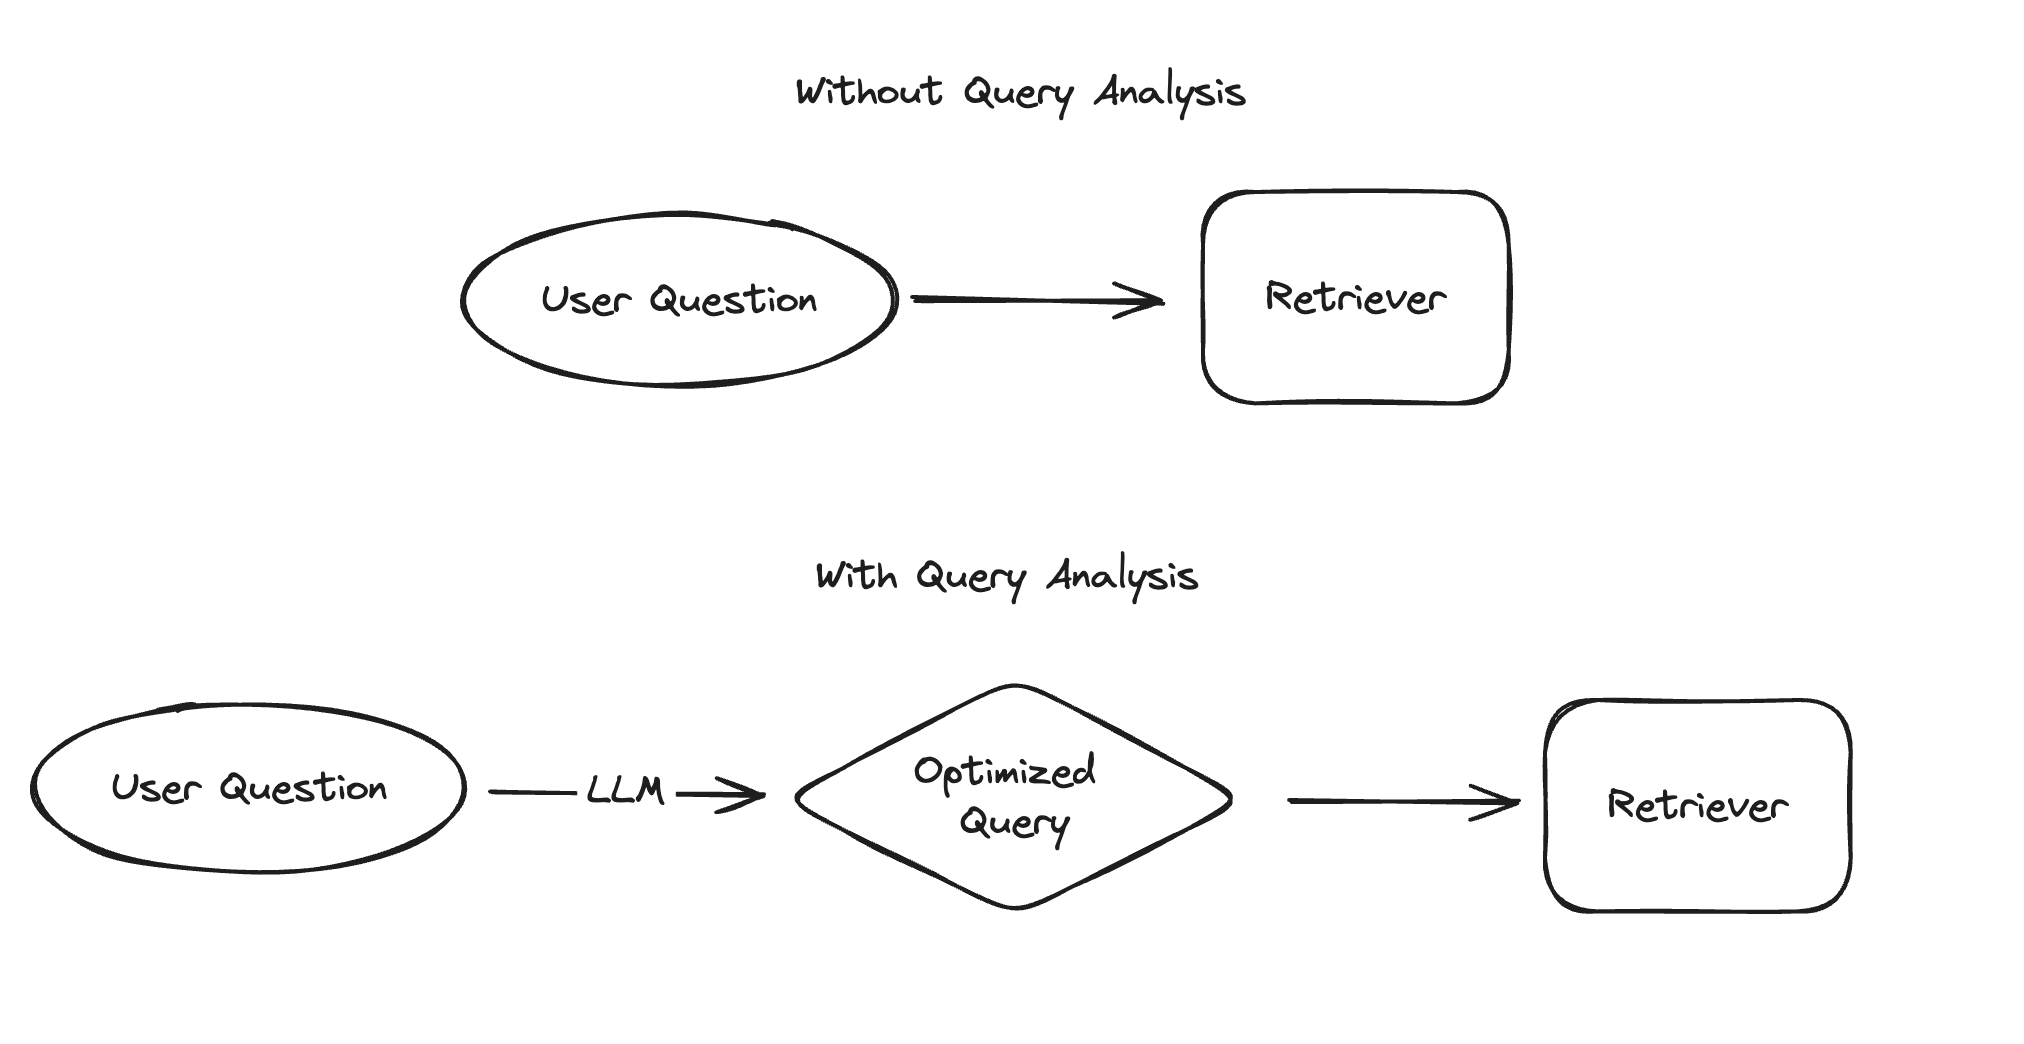
[Reference here](https://python.langchain.com/v0.1/docs/use_cases/query_analysis/)

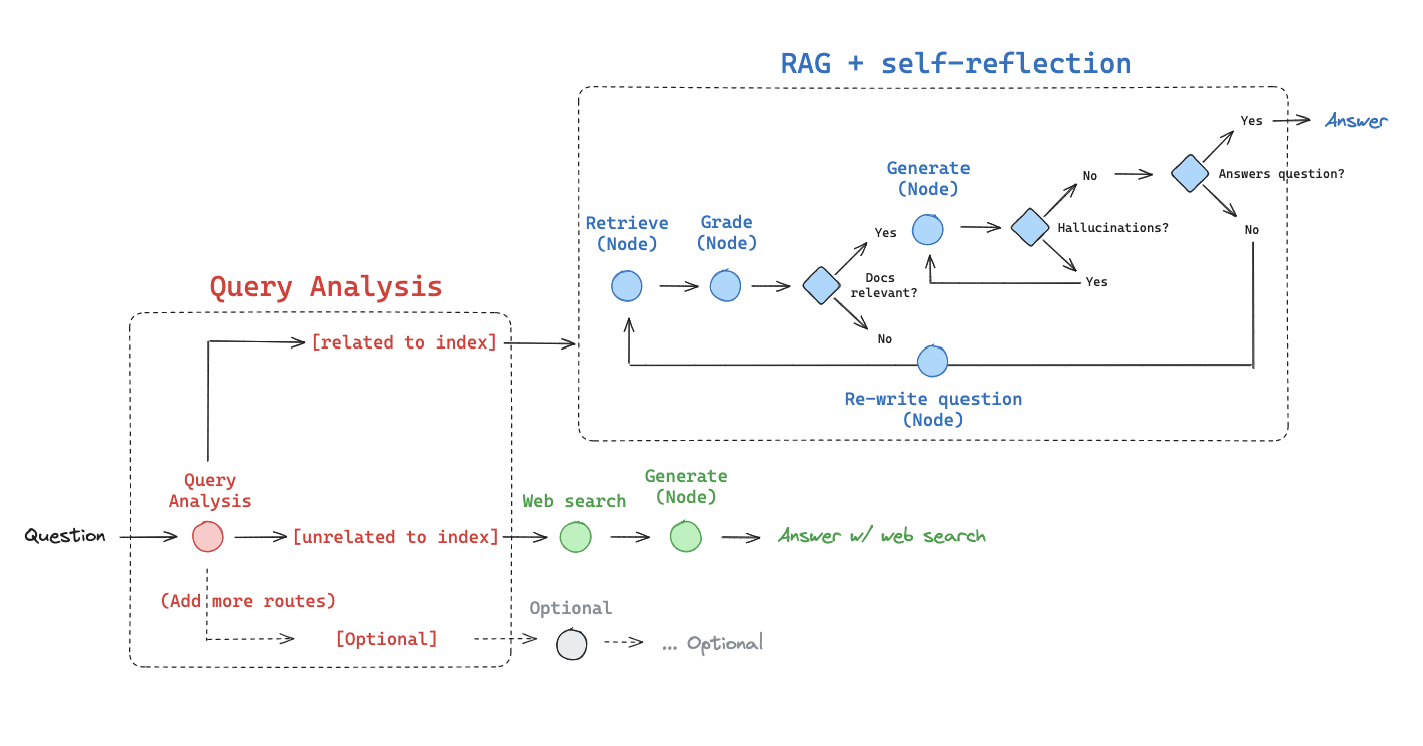
[Reference here](https://langchain-ai.github.io/langgraph/tutorials/rag/langgraph_adaptive_rag/)

In [68]:
from langgraph.graph import END, StateGraph, START

workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("web_search", web_search)  # web search
##STEP 6 ADD new node
workflow.add_node("retrieve", retrieve)  # retrieve
workflow.add_node("grade_documents", grade_documents)  # grade documents
workflow.add_node("generate", generate)  # generatae
workflow.add_node("transform_query", transform_query)  # transform_query
workflow.add_node("eden_tts", eden_tts_node)


# Build graph
# set_conditional_entry_point method doesn't require mentioning START
##STEP 7 MODIFY conditional edge for new tool here 
workflow.add_conditional_edges(
    START,
    route_question,
    {
        "web_search": "web_search",
        "vectorstore": "retrieve",
    },
)
workflow.add_edge("web_search", "generate")
##STEP 8 ##ADD edge for tool to END if invoking tool returns output /or/ ADD edge like Tavily, which connects to generate
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "transform_query": "transform_query",
        "generate": "generate",
    },
)
workflow.add_edge("transform_query", "retrieve")
workflow.add_conditional_edges(
    "generate",
    grade_generation_v_documents_and_question,
    {
        "not supported": "generate",
        "useful": "eden_tts",
        "not useful": "transform_query",
    },
)


workflow.add_edge("eden_tts",END)  # Ends after TTS conversion

# Compile
graph_4_adaptiverag = workflow.compile()

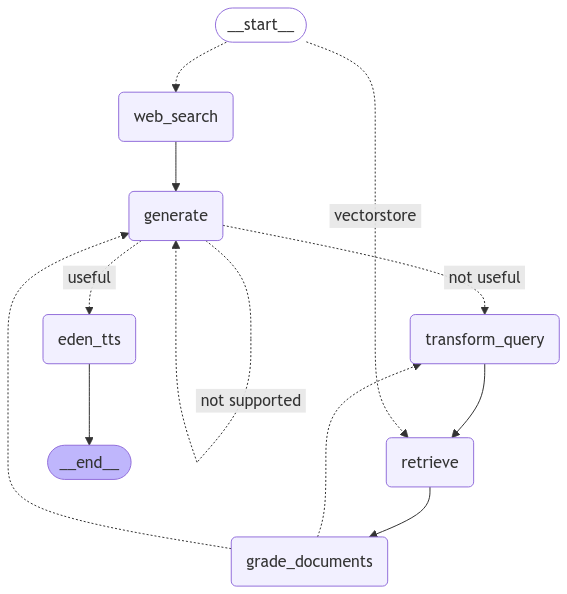

In [69]:
from IPython.display import Image, display

try:
    display(Image(graph_4_adaptiverag.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

## Use Graph

### For Question Not in Context

In [70]:
question_search

'Which players in IPL 2025 are expected to draw significant bids'

In [71]:
# Run
inputs = {
    "question": question_search
}

### For Question in Context

In [72]:
question_doc

'What are the highlights of the PGP in Data Science and AI course at Jio Institute'

In [73]:
# Run
inputs = {"question": question_doc}

In [ ]:
state = {"question": "What are the latest advancements in AI?"}
result = graph_4_adaptiverag.invoke(state)

# Ensure the result contains at least one of the required keys
if not any(key in result for key in ['question', 'generation', 'documents']):
	result['question'] = state['question']

print("Final Output:", result)

import IPython.display as ipd
import requests
from IPython.display import Audio, display

audio_url = result['generation']
# Fetch the audio content from the URL
response = requests.get(audio_url, stream=True)
response.raise_for_status()

# Save the audio content to a file
with open("audio.mp3", "wb") as f:
    for chunk in response.iter_content(chunk_size=8192):
        f.write(chunk)

# Play the audio file
display(Audio("audio.mp3", autoplay=True))

---ROUTE QUESTION---
---ROUTE QUESTION TO RAG---
---RETRIEVE---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: GENERATE---
---GENERATE---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---GRADE GENERATION vs QUESTION---
---DECISION: GENERATION ADDRESSES QUESTION---
Final Output: {'question': 'What are the latest advancements in AI?', 'generation': 'https://d14uq1pz7dzsdq.cloudfront.net/483fe092-863a-492f-bf37-ed63f7792789_.mp3?Expires=1739546634&Signature=WE2CAunSd9DhgS5aZjjidEeFMg-KDkn~CfKA-COLx2-KbmrW8DhhFULHRPMFo3WqnhG19gOYvs8rc2b4htVgf9buW6m88YliZ2c1ol4D6Ksscc0AxChN7UVUmJE76K8XB-MWoIT9tLhmXBOpxDHergEHZeXhfDMnSeYBvPiLrDWucMyFj5nz2Tw2~mp9PF1Dw5lhG~TYDNVMq2hlWvM3Lqz3OUmPjf4uu7ln1Y0na~Lwc~SKTYVmORhoKrUk2Oy7eMf4BgWFvqli1xJsg4NnsjqX56SxYOG~Nt2A2dZmU94~yVvp8-AGz8kckg23XIYOM-Ya925jrZJA-UelYbKbw